## Simple RNN Implementation

- with tanh activation

- with gradient clipping

### Author: Yifan Wang

In [119]:
import numpy as np
import matplotlib.pyplot as plt 

In [120]:
# Some Helper Functions:
def d_tanh(x):

    return 1 - np.tanh(x)*np.tanh(x)



In [121]:
def softmax(x):
    '''Softmax'''
    return np.exp(x) / np.sum(np.exp(x), axis=1,keepdims=1)


In [122]:
def d_softmax(x):
    J = x[..., None] * x[:, None, :]
    iy, ix = np.diag_indices_from(J[0])
    J[:, iy, ix] = x * (1. - x)
    return J.sum(axis=1)

Generally at each time step of forward, we do:

    a_now = activation_relu(Waa * a_previous + Wax * X_now  + ba)
    y_hat = sigmoid(activation_relu(Wya*a_now + by))
    

## Construct Data:

In [123]:
data = [
    'hello',
    'halo',
    'jello',
    'kello',
    'yello',
    'noon',
    'moon',
    'soon',
    'zoon',
    'ten'
]
data = [list(word) for word in data]

In [124]:
# Dict:
c2id = {v:k+1 for k,v in enumerate(set([j for i in data for j in i]))}
c2id

{'a': 7,
 'e': 13,
 'h': 9,
 'j': 2,
 'k': 12,
 'l': 3,
 'm': 11,
 'n': 4,
 'o': 10,
 's': 5,
 't': 6,
 'y': 1,
 'z': 8}

In [125]:
c2id[''] = 0

In [126]:
# Encoding:
def dat_encode(data,c2id):
    new_data =[]
    for word in data:
        new_word = []
        for char in word:
            new_word.append(c2id[char])
        new_data.append(new_word)
    return new_data

In [127]:
data = dat_encode(data,c2id)
data

[[9, 13, 3, 3, 10],
 [9, 7, 3, 10],
 [2, 13, 3, 3, 10],
 [12, 13, 3, 3, 10],
 [1, 13, 3, 3, 10],
 [4, 10, 10, 4],
 [11, 10, 10, 4],
 [5, 10, 10, 4],
 [8, 10, 10, 4],
 [6, 13, 4]]

In [128]:
Y = np.array([i[-1] for i in data])

In [129]:
Y

array([10, 10, 10, 10, 10,  4,  4,  4,  4,  4])

In [130]:
counter = 0
array_uniqueYs = np.unique(Y)

for uni_Y in array_uniqueYs:
    if counter not in np.unique(Y):
        Y[Y==uni_Y] = counter
        counter += 1


    

In [131]:
Y

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [132]:
Y = Y.tolist()

In [133]:
# Use all letters before to predict the last letter of each word:
X = [i[:-1] for i in data]
X

[[9, 13, 3, 3],
 [9, 7, 3],
 [2, 13, 3, 3],
 [12, 13, 3, 3],
 [1, 13, 3, 3],
 [4, 10, 10],
 [11, 10, 10],
 [5, 10, 10],
 [8, 10, 10],
 [6, 13]]

In [134]:
# post padding:
X = [word+[0]*(max([len(i) for i in X])-len(word)) for word in X]
X

[[9, 13, 3, 3],
 [9, 7, 3, 0],
 [2, 13, 3, 3],
 [12, 13, 3, 3],
 [1, 13, 3, 3],
 [4, 10, 10, 0],
 [11, 10, 10, 0],
 [5, 10, 10, 0],
 [8, 10, 10, 0],
 [6, 13, 0, 0]]

In [135]:
#OHE:
m = len(X) # sample size
n = len(c2id)+1 # feature size:
t = max([len(i) for i in X]) # time-step
print((m,n,t))

(10, 15, 4)


In [136]:
dat_mat = np.zeros((m,n,t))

In [137]:
ny = len(np.unique(Y))

y_mat = np.zeros((m,ny))

In [138]:
y_mat.shape

(10, 2)

In [139]:
# Data Preparation for Modeling:

for row in range(m):
    
    word = X[row]
    
    for ts in range(t):
        charidx = word[ts]
        
        dat_mat[row,charidx,ts] = 1
    
    yletteridx = Y[row]
    
    y_mat[row,yletteridx] = 1
    
    
        
    

In [140]:
dat_mat.shape

(10, 15, 4)

In [141]:
y_mat.shape

(10, 2)

## Modeling:

In [183]:
N_EPOCHS = 1000
N_HIDDEN = 50
LEARNING_RATE = 0.001


In [184]:
# Initialize Weight Matrix:
np.random.seed(0)
Wxa = 2*np.random.random((n,N_HIDDEN))-1
print("Wxa:{}".format(Wxa.shape))

Waa = 2*np.random.random((N_HIDDEN,N_HIDDEN))-1
print("Waa:{}".format(Waa.shape))


Way = 2*np.random.random((N_HIDDEN,ny))-1
print("Way:{}".format(Way.shape))


ba = np.zeros((1,N_HIDDEN))
print("ba:{}".format(ba.shape))

by = np.zeros((1,ny))
print("by:{}".format(by.shape))

a0 = 2*np.random.random((m,N_HIDDEN))-1
print("a0:{}".format(a0.shape))

a = 2*np.random.random((m,N_HIDDEN,t))-1
print("a:{}".format(a.shape))


y_pred = 2*np.random.random((m,ny,t))-1
print("y_pred:{}".format(y_pred.shape))

Wxa:(15, 50)
Waa:(50, 50)
Way:(50, 2)
ba:(1, 50)
by:(1, 2)
a0:(10, 50)
a:(10, 50, 4)
y_pred:(10, 2, 4)


In [185]:
parameters = {
    'Wxa':Wxa,
    'Waa':Waa,
    'Way':Way,
    'ba':ba,
    'by':by
}

In [186]:
all_error = []

In [187]:

for i in range(N_EPOCHS): # error after 10
    
    
    a_prev = a0
    caches = []
    overall_error = 0

    
    ##### Forward Propagate #####
    # initialization of  gradients
    dx = np.zeros((dat_mat.shape))#6-14-4  #m-n-t
    dWxa = np.zeros(Wxa.shape)
    dWaa = np.zeros(Waa.shape)
    dWay = np.zeros(Way.shape)
    dba = np.zeros(ba.shape)
    dby = np.zeros(by.shape)
    da0 = np.zeros(a0.shape)
    da = np.zeros(a.shape)
    da_prevt = np.zeros(a0.shape)


    layer_2_deltas = np.zeros((m,ny,t))

    
    print_error = 0
    for ts in range(t):
        # a-state, passing to next t-step
        a_next = np.tanh(np.dot(dat_mat[:,:,ts],Wxa) + np.dot(a_prev,Waa) + ba)  # m-hidden
        a[:,:,ts] = a_next
        # prediction of current time step:
        yt_pred = softmax(np.dot(a_next,Way)+by)
        y_pred[:,:,ts] = yt_pred  
        # save a for next t-step
        a_prev = a_next
        # cost of current t-step:
        cost = y_mat-yt_pred
        # output layer error rate : error* dtanh()
        layer_2_delta=cost*d_softmax(yt_pred)
        layer_2_deltas[:,:,ts] = layer_2_delta #6-14
        print_error=np.sum(np.abs(cost))
        cache = (a_next, a_prev, dat_mat[:,:,ts], parameters)
        caches.append(cache)
        #######################
    
    all_error.append(print_error)
    
    if i%10==0:
        print('Epoch {}'.format(i))
        print_pred = np.argmax(yt_pred,axis=-1)
        print("Predicted:{}".format(print_pred))
        print("Actual:{}".format(np.argmax(y_mat,axis=-1)))
        print("Error:{}".format( print_error))
        print('=====================')





        


        

    # Prepare:
    #Get pars from f-prop:
    (a1, a0, x1, parameters) = caches[0]
    # initialize:
    next_delta = np.zeros((m,N_HIDDEN))
    # Figure out how to get Da

    
    
    
    
    
    # Back Propagate:
    for ts in reversed(range(t)):
        cache = caches[ts]
        (a_now, a_prev, x_now, parameters) = cache
        Wxa = parameters["Wxa"]
        Waa = parameters["Waa"]
        Way = parameters["Way"]
        ba = parameters["ba"]
        by = parameters["by"]
        # y_pred error rate
        layer_2_delta = layer_2_deltas[:,:,ts]
        # propagate back:

        

#         else:
#             da_now = np.dot(next_delta,Waa)**d_tanh(a_now)

        # update the prediction_t branch:
        dWayt = np.dot(a_now.T,layer_2_delta)
        
        
        #update the first layer: Waa, Wxa by  combining a_now and y_pred output
        # next_delta:  delta from next_time_step's  a
        # layer_2_delta: error rate from this time step's Y_pred
#         if ts ==t-1:
        da_now = (np.dot(next_delta,Waa) +  np.dot(layer_2_delta,Way.T))*d_tanh(a_now)      
#         else: 
#             da_now = (np.dot(next_delta,Waa))*d_tanh(a_now) 
            
            
        dWaat = np.dot( da_now.T,a_prev) #20-20
        dWxat = np.dot(x_now.T,da_now) # 14-20
        dbat = np.sum( d_tanh(a_now),keepdims=True,axis=0)
        next_delta = da_now
        dxt = np.dot(da_now,Wxa.T)#6-14


        

        
        
        dWxa += dWxat
        dWaa += dWaat
        dWay += dWayt
        dba += dbat


    # Gradient Clipping to avoid Gradient Exploding:
    dWxa = np.clip(dWxa,-50,50)
    dWaa = np.clip(dWaa,-50,50)
    dWay = np.clip(dWay,-50,50)
    dba = np.clip(dba,-50,50)


    # Updating
    Wxa+=LEARNING_RATE*dWxa
    Waa+=LEARNING_RATE*dWaa
    Way+=LEARNING_RATE*dWay
    ba+=LEARNING_RATE*dba

    # resetting
    dWxat *= 0 
    dWaat *= 0
    dWayt *= 0  
    dbat  *= 0
    
    
    
    
    


Epoch 0
Predicted:[1 0 1 1 0 0 0 1 1 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:6.1618266663963945
Epoch 10
Predicted:[0 0 0 0 0 0 1 0 1 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:13.086877401232588
Epoch 20
Predicted:[0 0 1 0 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:5.709503980596753
Epoch 30
Predicted:[0 0 0 0 0 0 0 0 1 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:9.618305524879649
Epoch 40
Predicted:[1 0 0 0 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:7.192302815048875
Epoch 50
Predicted:[0 0 1 0 0 1 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:10.847579227927024
Epoch 60
Predicted:[0 0 0 0 0 1 1 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:11.58851505394955
Epoch 70
Predicted:[0 1 0 0 1 1 1 1 1 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:11.447234965318613
Epoch 80
Predicted:[1 0 1 1 1 1 1 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:9.862987382218874
Epoch 90
Predicted:[1 1 1 1 1 1 1 1 1 1]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:9.7936623195593
Epoch 100
Predicted:[1 1 1 1 1 1 1 1 1 1]
Actual:[1 1 1 1 1

Epoch 900
Predicted:[1 1 1 1 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:0.176509970965246
Epoch 910
Predicted:[1 1 1 1 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:0.1753793979254859
Epoch 920
Predicted:[1 1 1 1 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:0.1742735802248656
Epoch 930
Predicted:[1 1 1 1 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:0.17319164002551826
Epoch 940
Predicted:[1 1 1 1 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:0.17213274326848335
Epoch 950
Predicted:[1 1 1 1 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:0.1710960965847359
Epoch 960
Predicted:[1 1 1 1 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:0.17008094450486638
Epoch 970
Predicted:[1 1 1 1 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:0.16908656693354993
Epoch 980
Predicted:[1 1 1 1 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:0.16811227685880228
Epoch 990
Predicted:[1 1 1 1 1 0 0 0 0 0]
Actual:[1 1 1 1 1 0 0 0 0 0]
Error:0.16715741826938466


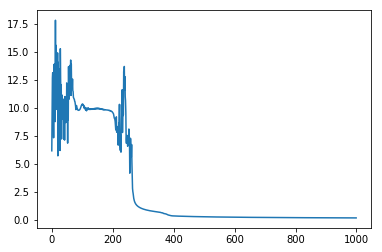

In [188]:
plt.plot(all_error)
